Loaded InteractiveDE extension version 1.0.1a0
Extension enabled for altair


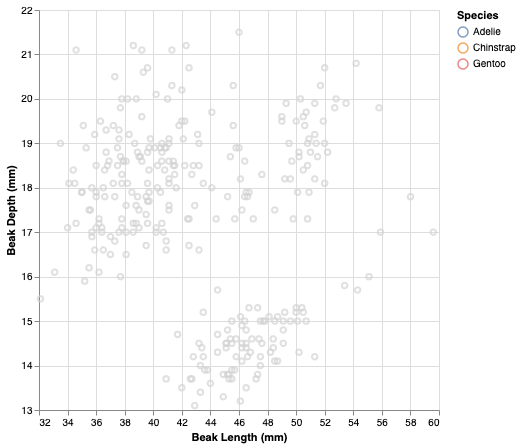

In [50]:
import altair as alt
import pandas as pd

import interactivede.ide as IDE # Our library

IDE.enable('altair') # Call this to enable integration with altair

penguins_url = "https://raw.githubusercontent.com/vega/vega/master/docs/data/penguins.json"

# All of the code here is pure altair. The library does not need any custom syntax

brush = alt.selection_interval(name='brush', empty='none') # define a type of selection
# brush = alt.selection_interval(name='brush') # define a type of selection

# create a scatterplot
chart = alt.Chart(penguins_url).mark_point().encode(
    x=alt.X('Beak Length (mm):Q', scale=alt.Scale(zero=False)),
    y=alt.Y('Beak Depth (mm):Q', scale=alt.Scale(zero=False)),
    color=alt.condition(brush, 'Species:N', alt.value('lightgray'))
).properties(
    width=400,
    height=400
).add_selection(
    brush # Connect the brush selection to scatterplot
)

chart